# Prediction of energy consumption of non-residential buildings in San Francisco

July 2019

*Project Description:*

We will use this dataset to analyse and predict the Froth floating process having the two aims:

What is the best predictor for the iron concentration of the product?
Can the data set be used to predict the impurity of the product (by silicate concentration)?

*Data Description:*

This notebook deals with the analysis of a reverse cationic flotation process of a real production environment. The data (including its documentation) is accessible through kaggle: https://www.kaggle.com/san-francisco/sf-commercial-buildings-energy-performance-report/downloads/sf-commercial-buildings-energy-performance-report.zip/104

---

## Data Analysis
We start our analysis by importing required libraries:

In [232]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

%matplotlib inline
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt; plt.style.use('seaborn-colorblind')
import seaborn as sns; sns.set(style="ticks", color_codes=True)
import datetime as dt

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split
from IPython.display import display
from sklearn import metrics

# include fasti.ai libraries
from fastai.tabular import *

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
from IPython.display import display
pd.set_option('display.max_columns', None) # display all columns

# Any results you write to the current directory are saved as output.

We load the data and drop some columns that dont seem to be useful for our analysis:

In [166]:
#PATH = 'existing-commercial-buildings-energy-performance-ordinance-report.csv'
PATH = 'spain_energy_market.csv'
#nRowsRead = 1
#df_null = pd.read_csv(PATH,nrows = nRowsRead)

#all_cols = df_null.columns
#skipcols = ['Full.Address','PIM Link',':@computed_region_f58d_8dbm',':@computed_region_vtsz_7cme',':@computed_region_rxqg_mtj9',':@computed_region_jx4q_fizf']

#df = pd.read_csv(PATH,usecols=set(all_cols) - set(skipcols))
df = pd.read_csv(PATH, parse_dates = True, date_parser = 'datetime')

Let's have a look at the data:

In [159]:
df.head()

,datetime,id,name,geoid,geoname,value
0,2014-01-01 23:00:00,600,Precio mercado SPOT Diario ESP,3.0,España,25.280833
1,2014-01-02 23:00:00,600,Precio mercado SPOT Diario ESP,3.0,España,39.924167
2,2014-01-03 23:00:00,600,Precio mercado SPOT Diario ESP,3.0,España,4.992083
3,2014-01-04 23:00:00,600,Precio mercado SPOT Diario ESP,3.0,España,4.091667
4,2014-01-05 23:00:00,600,Precio mercado SPOT Diario ESP,3.0,España,13.587500


Lets create additional Time data columns:

In [167]:
df['date'] = pd.to_datetime(df['datetime'])
df['dayofweek'] = df['date'].dt.dayofweek
df['quarter'] = df['date'].dt.quarter
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year
df['dayofyear'] = df['date'].dt.dayofyear
df['dayofmonth'] = df['date'].dt.day
df['weekofyear'] = df['date'].dt.weekofyear
df = df.set_index(['date'])

In [168]:
df.drop(['datetime'], axis=1,inplace=True)

In [163]:
df['name'].unique()

array(['Precio mercado SPOT Diario ESP', 'Precio mercado SPOT Diario FRA', 'Precio mercado SPOT Diario POR',
       'Energía asignada en Mercado SPOT Diario España', 'Energía asignada en Mercado SPOT Diario Francia', nan,
       'Rentas de congestión mecanismos implícitos diario Francia exportación',
       'Rentas de congestión mecanismos implícitos diario Portugal exportación',
       'Rentas de congestión mecanismos implícitos diario Francia importación',
       'Rentas de congestión mecanismos implícitos diario Portugal importación', 'Demanda real',
       'Demanda programada PBF total', 'Generación programada PBF total', 'Generación programada PBF Eólica',
       'Generación programada PBF Ciclo combinado', 'Generación programada PBF Carbón',
       'Generación programada PBF Nuclear', 'Generación programada PBF Gas Natural Cogeneración',
       'Generación programada PBF UGH + no UGH', 'Generación programada PBF Solar fotovoltaica',
       'Generación programada PBF Turbinación b

Since multiple time series are contained in our column data, we need to seperate the different features. Lets create new dataframes of the 'real Demand' the 'scheduled Demand' and the 'Daily spot Spain market price'.

In [233]:
Demand_real  = df[df['name'] == 'Demanda real']
Demand_sche  = df[df['name'] == 'Demanda programada PBF total']
Price        = df[df['name'] == 'Precio mercado SPOT Diario ESP']
Price.head()

,id,name,geoid,geoname,value,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
date,,,,,,,,,,,,,
2014-01-01 23:00:00,600,Precio mercado SPOT Diario ESP,3.0,España,25.280833,23,2,1,1,2014,1,1,1
2014-01-02 23:00:00,600,Precio mercado SPOT Diario ESP,3.0,España,39.924167,23,3,1,1,2014,2,2,1
2014-01-03 23:00:00,600,Precio mercado SPOT Diario ESP,3.0,España,4.992083,23,4,1,1,2014,3,3,1
2014-01-04 23:00:00,600,Precio mercado SPOT Diario ESP,3.0,España,4.091667,23,5,1,1,2014,4,4,1
2014-01-05 23:00:00,600,Precio mercado SPOT Diario ESP,3.0,España,13.587500,23,6,1,1,2014,5,5,1


Price development over whole timespan:

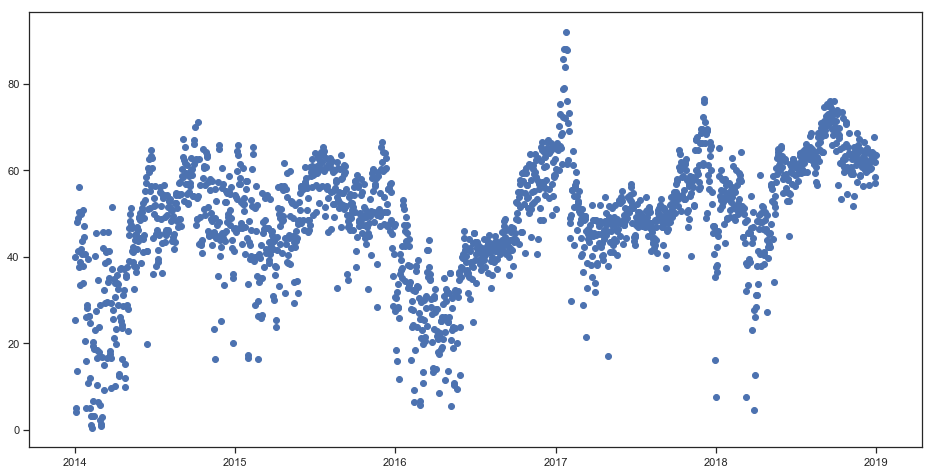

In [271]:
plt.figure(figsize=(16,8))
plt.scatter(x=Price.index,y=Price['value'])

We can see that the price development undergoes some seasonal changes. To further explore this, lets visualize the data for different time attributes, like price per day of week, week of year, quarter and year.

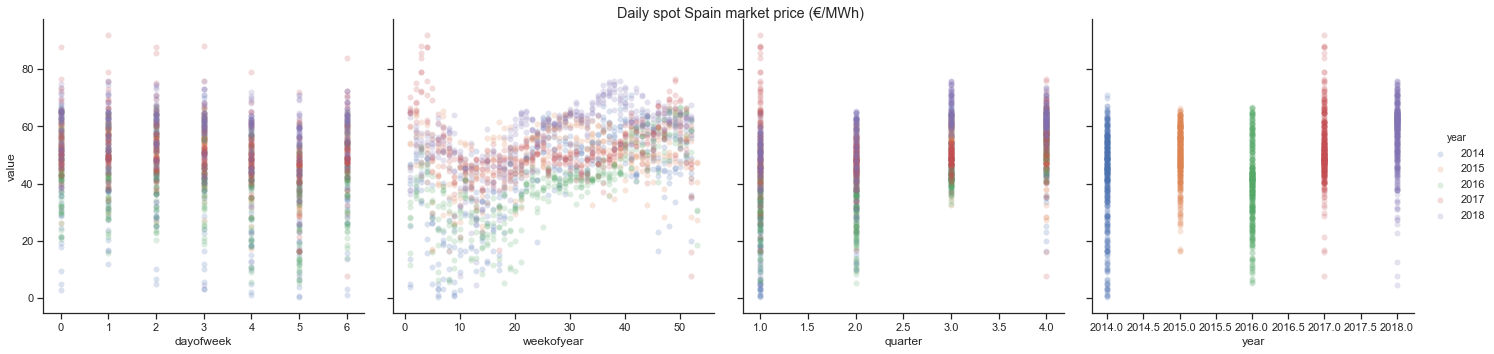

In [228]:
sns.pairplot(Price,
             hue='year',
             x_vars=['dayofweek','weekofyear','quarter','year'],
             y_vars='value',
             height=5,
             plot_kws={'alpha':0.2, 'linewidth':0}
            )
plt.suptitle('Daily spot Spain market price (€/MWh)')
plt.show()

We repeat this for the expected energy demand and the actual demand...

<Figure size 1152x720 with 0 Axes>

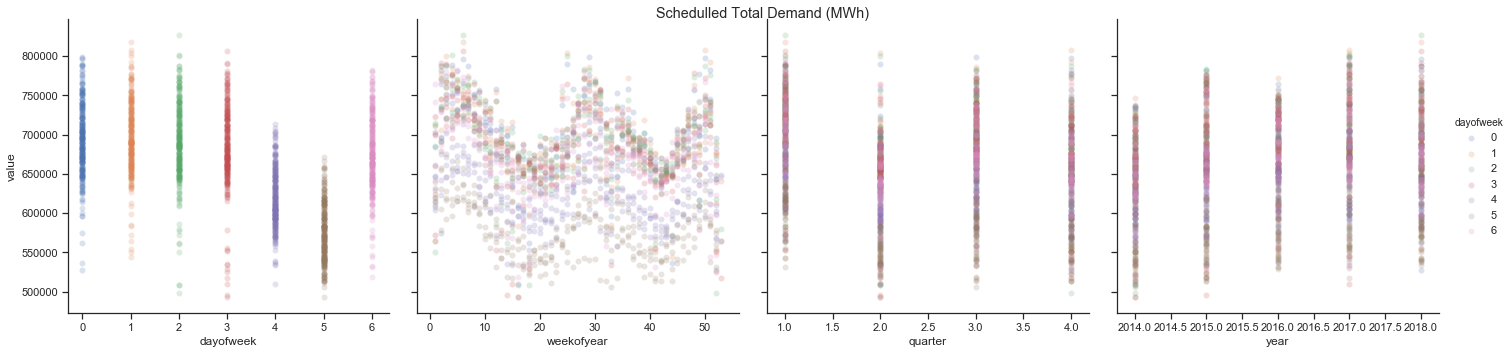

In [229]:
plt.figure(figsize=(16,10))
sns.pairplot(Demand_sche,
             hue='dayofweek',
             x_vars=['dayofweek','weekofyear','quarter','year'],
             y_vars='value',
             height=5,
             plot_kws={'alpha':0.2, 'linewidth':0}
            )
plt.suptitle('Schedulled Total Demand (MWh)')
plt.show()

<Figure size 1152x720 with 0 Axes>

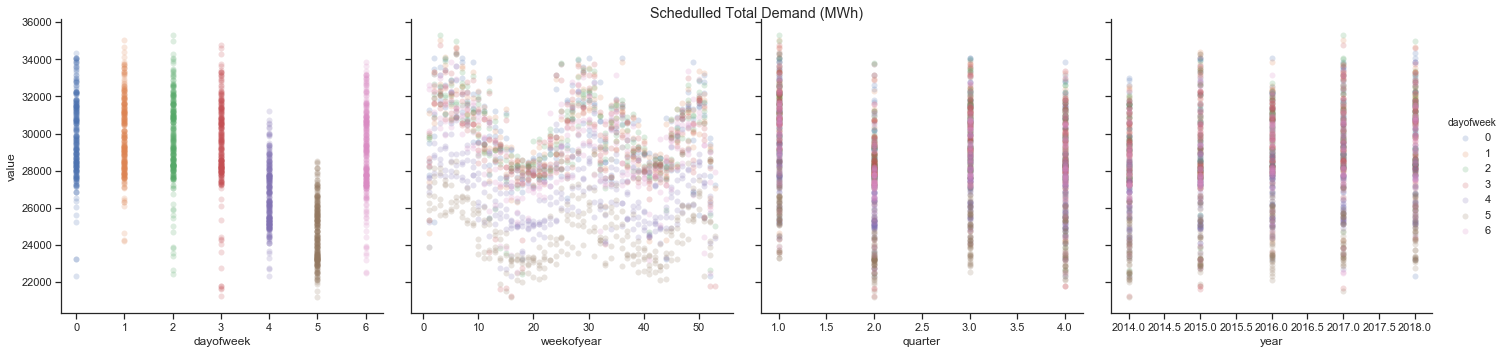

In [230]:
plt.figure(figsize=(16,10))
sns.pairplot(Demand_real,
             hue='dayofweek',
             x_vars=['dayofweek','weekofyear','quarter','year'],
             y_vars='value',
             height=5,
             plot_kws={'alpha':0.2, 'linewidth':0}
            )
plt.suptitle('Schedulled Total Demand (MWh)')
plt.show()

### Observations

Based on our quick visualization we can derive the following observations:

- the daily market price has a long-term dependency (quarterly or yearly fluctuations), while
- the demand seems to be strongly influenced by the days of the week (see drop on fridays and saturdays)

## Prediction of daily price

Lets see if we can predict the market price. We start by splitting the data into training and test set. Lets take the 2018-01-01 as split-date.

In [252]:
date_split = '2018-01-01'
train = Price['value'].loc[Price.index <= date_split].copy()
train = train.reset_index()
test = Price['value'].loc[Price.index > date_split].copy()
test = test.reset_index()
test.head()

,date,value
0,2018-01-01 23:00:00,37.690000
1,2018-01-02 23:00:00,37.947917
2,2018-01-03 23:00:00,36.551667
3,2018-01-04 23:00:00,42.204583
4,2018-01-05 23:00:00,45.844167


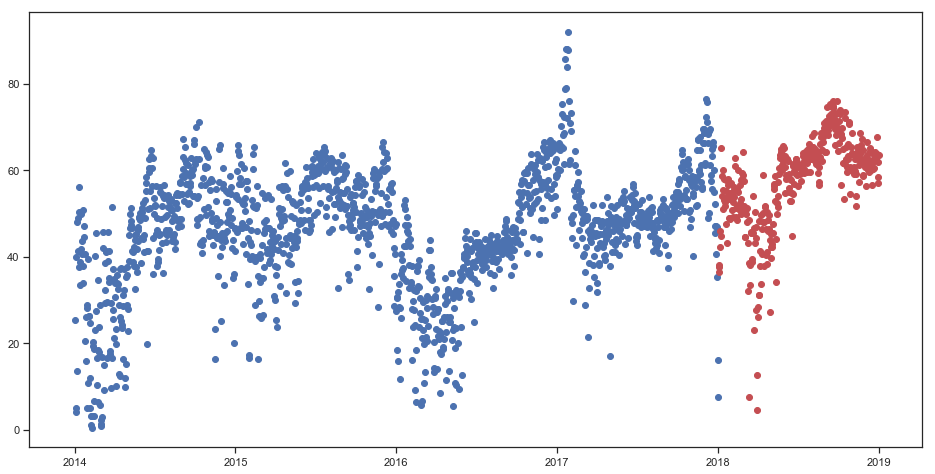

In [273]:
plt.figure(figsize=(16,8))
plt.scatter(x=train['date'],y=train['value'],c='b')
plt.scatter(x=test['date'],y=test['value'],c='r')


Now, we train a Prophet model from Facebook (https://facebook.github.io/prophet/), used to forecast time series that undergo seasonal trends.

In [275]:
from fbprophet import Prophet

ModuleNotFoundError: No module named 'fbprophet'

In [274]:
model = Prophet()
model.fit(train.rename(columns={'date':'ds', 'value':'y'}))

NameError: name 'Prophet' is not defined

Data types are:

In [71]:
df.dtypes

datetime     object
id            int64
name         object
geoid       float64
geoname      object
value       float64
dtype: object

And here the descriptive statistics:

In [58]:
df.describe()

,Postal Code,Floor Area,Year Built,2018 ENERGY STAR Score,2018 Site EUI (kBtu/ft2),2018 Source EUI (kBtu/ft2),2018 Percent Better than National Median Site EUI,2018 Percentage Better than National Median Source EUI,2018 Total GHG Emissions (Metric Tons CO2e),2018 Total GHG Emissions Intensity (kgCO2e/ft2),2018 Weather Normalized Site EUI (kBtu/ft2),2018 Weather Normalized Source EUI (kBtu/ft2),2017 ENERGY STAR Score,2017 Site EUI (kBtu/ft2),2017 Source EUI (kBtu/ft2),2017 Percent Better than National Median Site EUI,2017 Percentage Better than National Median Source EUI,2017 Total GHG Emissions (Metric Tons CO2e),2017 Total GHG Emissions Intensity (kgCO2e/ft2),2017 Weather Normalized Site EUI (kBtu/ft2),2017 Weather Normalized Source EUI (kBtu/ft2),2016 ENERGY STAR Score,2016 Site EUI (kBtu/ft2),2016 Source EUI (kBtu/ft2),2016 Percent Better than National Median Site EUI,2016 Percentage Better than National Median Source EUI,2016 Total GHG Emissions (Metric Tons CO2e),2016 Total GHG Emissions Intensity (kgCO2e/ft2),2016 Weather Normalized Site EUI (kBtu/ft2),2016 Weather Normalized Source EUI (kBtu/ft2),2015 ENERGY STAR Score,2015 Site EUI (kBtu/ft2),2015 Source EUI (kBtu/ft2),2015 Percent Better than National Median Site EUI,2015 Percentage Better than National Median Source EUI,2015 Total GHG Emissions (Metric Tons CO2e),2015 Total GHG Emissions Intensity (kgCO2e/ft2),2015 Weather Normalized Site EUI (kBtu/ft2),2015 Weather Normalized Source EUI (kBtu/ft2),2014 ENERGY STAR Score,2014 Site EUI (kBtu/ft2),2014 Source EUI (kBtu/ft2),2014 Percent Better than National Median Site EUI,2014 Percent Better than National Median Source EUI,2014 Total GHG Emissions (Metric Tons CO2e),2014 Total GHG Emissions Intensity (kgCO2e/ft2),2014 Weather Normalized Site EUI (kBtu/ft2),2014 Weather Normalized Source EUI (kBtu/ft2),2013 ENERGY STAR Score,2013 Site EUI (kBtu/ft2),2013 Source EUI (kBtu/ft2),2013 Percent Better than National Median Site EUI,2013 Percent Better than National Median Source EUI,2013 Total GHG Emissions (Metric Tons CO2e),2013 Total GHG Emissions Intensity (kgCO2e/ft2),2013 Weather Normalized Site EUI (kBtu/ft2),2013 Weather Normalized Source EUI (kBtu/ft2),2012 ENERGY STAR Score,2012 Site EUI (kBtu/ft2),2012 Source EUI (kBtu/ft2),2012 Percent Better than National Median Site EUI,2012 Percent Better than National Median Source EUI,2012 Total GHG Emissions (Metric Tons CO2e),2012 Total GHG Emissions Intensity (kgCO2e/ft2),2012 Weather Normalized Site EUI (kBtu/ft2),2012 Weather Normalized Source EUI (kBtu/sq.ft),2011 ENERGY STAR Score,2011 Site EUI (kBtu/ft2),2011 Source EUI (kBtu/ft2),2011 Percent Better than National Median Site EUI,2011 Percent Better than National Median Source EUI,2011 Total GHG Emissions (Metric Tons CO2e),SF Find Neighborhoods,2011 Total GHG Emissions Intensity (kgCO2e/ft2),Current Police Districts,2011 Weather Normalized Site EUI (kBtu/ft2),Current Supervisor Districts,Analysis Neighborhoods,2011 Weather Normalized Source EUI (kBtu/ft2)
count,2915.000000,2.915000e+03,2775.000000,643.000000,917.000000,917.000000,900.000000,900.000000,917.000000,917.000000,906.000000,906.000000,830.000000,1196.000000,1195.000000,1174.000000,1174.000000,1195.000000,1195.000000,1178.000000,1178.000000,824.000000,1204.000000,1203.000000,1184.000000,1184.000000,1202.000000,1202.000000,1177.000000,1179.000000,833.000000,1207.000000,1207.000000,1086.000000,1086.000000,1206.000000,1206.000000,1190.000000,1190.000000,805.000000,1177.000000,1177.000000,1110.000000,1110.000000,1176.000000,1176.000000,1159.000000,1159.000000,759.000000,1098.000000,1098.000000,1076.000000,1076.000000,1097.000000,1096.000000,1083.000000,1083.000000,469.000000,635.000000,635.000000,626.000000,132.000000,632.000000,139.000000,631.000000,631.000000,335.000000,419.000000,34.000000,411.000000,35.000000,4.160000e+02,2881.000000,35.000000,2880.000000,419.000000,2882.000000,2881.000000,35.000000
mean,94111.089537,1.180943e+05,1886.197838,69.430793,64.474

The number of null entries per feature:

In [61]:
df.isnull().sum().sort_values(ascending = True)

Parcel(s)                                                 0
Building Name                                             0
Building Address                                          0
Postal Code                                               0
Floor Area                                                0
Property Type                                             0
Benchmark 2018 Status                                     0
Current Supervisor Districts                             33
Analysis Neighborhoods                                   34
SF Find Neighborhoods                                    34
Current Police Districts                                 35
Year Built                                              140
Property Type - Self Selected                          1236
Benchmark 2016 Status                                  1238
Benchmark 2017 Status                                  1238
Benchmark 2015 Status                                  1239
Benchmark 2014 Status                   